<a href="https://colab.research.google.com/github/Neil2DP/Time-Series-Forecast/blob/master/FGSM_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
# import theano as th
# import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
# from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras

# 新段落

In [ ]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/RML2016.10a_dict.pkl",'rb'),encoding='latin')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [ ]:
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(64, 1, 3, padding='valid', activation="relu", name="conv1"))#, init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(16, 1, 3, padding="valid", activation="relu", name="conv2"))#, init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(128, activation='relu', name="dense1"))#, init='he_normal'
model.add(Dropout(dr))
model.add(Dense( len(classes), name="dense2" ))#, init='he_normal'
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model_input_layer  = model.layers[0].input  #输入层的变量控制
model_output_layer = model.layers[-1].output#输出层的变量控制
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 1, 6, 128)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 1, 2, 64)          8256      
                                                                 
 dropout (Dropout)           (None, 1, 2, 64)          0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 1, 6, 64)         0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 1, 2, 16)          1

In [ ]:
# Set up some params
nb_epoch = 200     # number of epochs to train on
batch_size = 1024  # training batch siz

# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    #show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        #keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

# Show simple version of performance
score = model.evaluate(X_test, Y_test,
                       #show_accuracy=True,
                       verbose=0, batch_size=batch_size)
print(score)

Epoch 1/200
108/108 - 5s - loss: 2.3545 - val_loss: 2.2422 - 5s/epoch - 45ms/step
Epoch 2/200
108/108 - 3s - loss: 2.2521 - val_loss: 2.2301 - 3s/epoch - 23ms/step
Epoch 3/200
108/108 - 4s - loss: 2.2371 - val_loss: 2.2155 - 4s/epoch - 33ms/step
Epoch 4/200
108/108 - 2s - loss: 2.2181 - val_loss: 2.1881 - 2s/epoch - 22ms/step
Epoch 5/200
108/108 - 3s - loss: 2.1935 - val_loss: 2.1448 - 3s/epoch - 23ms/step
Epoch 6/200
108/108 - 3s - loss: 2.1588 - val_loss: 2.0883 - 3s/epoch - 25ms/step
Epoch 7/200
108/108 - 3s - loss: 2.1280 - val_loss: 2.0511 - 3s/epoch - 27ms/step
Epoch 8/200
108/108 - 3s - loss: 2.1068 - val_loss: 2.0326 - 3s/epoch - 28ms/step
Epoch 9/200
108/108 - 2s - loss: 2.0916 - val_loss: 2.0066 - 2s/epoch - 20ms/step
Epoch 10/200
108/108 - 2s - loss: 2.0772 - val_loss: 1.9945 - 2s/epoch - 14ms/step
Epoch 11/200
108/108 - 2s - loss: 2.0595 - val_loss: 1.9743 - 2s/epoch - 14ms/step
Epoch 12/200
108/108 - 2s - loss: 2.0496 - val_loss: 1.9668 - 2s/epoch - 14ms/step
Epoch 13/200


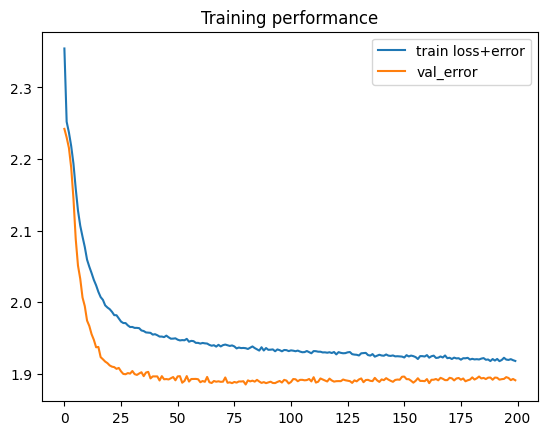

In [ ]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()


In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

108/108 [==============================] - 0s 3ms/step


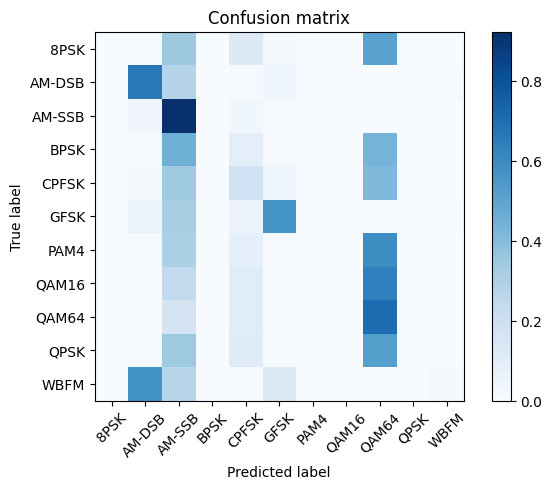

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)      # !!!
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
    

ValueError: ignored

In [ ]:
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)##############
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor + ncor))
    acc[snr] = 1.0 * cor / (cor + ncor)


In [ ]:
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )


In [ ]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")


# FGSM signal


### **导入库和数据库1**

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.applications import inception_v3
from keras import backend as K
from PIL import Image

import matplotlib.pyplot as plt
from keras.models import Model
import keras
#/content/drive/MyDrive/Colab Notebooks/RML2016.10a_dict.pkl
f = open(r"/content/drive/MyDrive/Colab Notebooks/RML2016.10a_dict.pkl", 'rb')
Xd = pickle.load(f, encoding='bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])  # set()创建一个无序的不重复元素序列
print(snrs, mods)
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):  lbl.append((mod, snr))  # append末尾添加对象
X = np.vstack(X)

mods_str = []
for i in mods:
    mods_str.append(str(i).split('\'')[1])

np.random.seed(2016)
n_examples = X.shape[0]  # int 162060
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0, n_examples), size=int(n_train), replace=False)  # ndarray with shape (81030,)
test_idx = list(set(range(0, n_examples)) - set(train_idx))  # list (81030 items total)

X_train = X[train_idx]  # ndarray with shape (81030, 2, 128)
X_test = X[test_idx]  # 同上
lbl_no = np.vstack(lbl)  # 这一步骤没必要，因为可以直接使用lbl去取出来调制方式

lbl_mods = lbl_no[0]

Y_train_no = list(map(lambda x: mods.index(lbl[x][0]), train_idx))  # 显示的是0-10数字表示调制方式list (81030 items total)

Y_train_no = np.vstack(Y_train_no)  # # ndarray with shape (81030, 1)

Y_test_no = list(map(lambda x: mods.index(lbl[x][0]), test_idx))
Y_test_no = np.vstack(Y_test_no)

Y_train_mod = lbl_no[:, 0]
Y_train_mod_vsatck = np.vstack(Y_train_mod)  # 字幕显示调制方式

Y_train_snrs = list(map(lambda x: snrs.index(lbl[x][1]), train_idx))

Y_train_snrs = np.vstack(Y_train_snrs)
Y_test_snrs = list(map(lambda x: snrs.index(lbl[x][1]), test_idx))
Y_test_snrs = np.vstack(Y_test_snrs)

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))  # ndarray with shape (81030, 11)

in_shp = list(X_train.shape[1:])  # list [2, 128]

classes = mods  # list [b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM'] (11 items total)

mods_str = []
for i in mods:
    mods_str.append(str(i).split('\'')[1])
# print(mods_str)  # list ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']

#

"""##Neural Networks
###CNN
"""
from keras.models import Sequential
from keras.layers import Conv1D, Convolution2D, Flatten, Dense, Reshape,Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers

model = Sequential()
in_shp = [2, 128]
model.add(Reshape([1]+in_shp, input_shape=in_shp))
# model.add(Conv2D(filters=64, kernel_size=(1,3), data_format='channels_first', activation='relu', padding='valid'))
# model.add(Conv2D(filters=16, kernel_size=(2,3), data_format='channels_first', activation='relu', padding='valid'))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(64,1,3,padding='valid', activation="relu", name="conv1"))#, init='glorot_uniform'))
# model.add(ZeroPadding2D(0,2))
model.add(Dropout(0.2))
model.add(Convolution2D(16,1,3,padding='valid', activation="relu", name="conv2"))#, init='glorot_uniform'))  # 改了（16，2，3）
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()





[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18] [b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 1, 6, 128)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 1, 2, 64)          8256      
                                                                 
 dropout_7 (Dropout)         (None, 1, 2, 64)          0         
                                                                 
 conv2 (Conv2D)              (None, 1, 1, 16)          1040    

### **导入库和数据库2**

In [90]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
#%matplotlib inline
import os,random
# from sys import path
# path.append(r"d:\programe\anaconda\lib\site-packages")#导入需要接入的文件路径
# path.append(r"D:\programe\anaconda\Scripts")#导入需要接入的文件路径

os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
# import theano as th
# import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
#from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from keras import backend as K
# Load the dataset ...
#  You will need to seperately download or generate this file
##Xd = cPickle.load(open("RML2016.10a_dict.dat",'rb'))
import pickle
import numpy as np
Xd = pickle.load(open(r"/content/drive/MyDrive/Colab Notebooks/RML2016.10a_dict.pkl", 'rb'),encoding='latin')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
X = []
lbl = []

snrs = [18]#snrs[-1:]
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):  lbl.append((mod, snr))
X = np.vstack(X)

#归一化
#X = (X - X.min()*np.ones([11000,2,128]))/(X.max()-X.min())#
# %%
np.random.seed(2016)  # 对预处理好的数据进行打包，制作成投入网络训练的格式，并进行one-hot编码
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0, n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0, n_examples)) - set(train_idx))  # label
X_train = X[train_idx]
X_test = X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1
trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))



# snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
# X = []
# lbl = []
# for mod in mods:
#     for snr in snrs:
#         X.append(Xd[(mod,snr)])
#         for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
# X = np.vstack(X)

# # Partition the data
# #  into training and test sets of the form we can train/test on
# #  while keeping SNR and Mod labels handy for each
# np.random.seed(2016)
# n_examples = X.shape[0]
# #print(type(n_train))
# n_train = n_examples * 0.5
# train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
# test_idx = list(set(range(0,n_examples))-set(train_idx))
# X_train = X[train_idx]
# X_test =  X[test_idx]
# def to_onehot(yy):
#     yy1 = np.zeros([len(yy), max(yy)+1])
#     yy1[np.arange(len(yy)),yy] = 1
#     return yy1
# #print(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
# Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
# Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))



in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

# Build VT-CNN2 Neural Net model using Keras primitives --
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization



dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, padding='valid', activation="relu", name="conv1"))#, init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, padding="valid", activation="relu", name="conv2"))#, init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', name="dense1"))#, init='he_normal'
model.add(Dropout(dr))
model.add(Dense( len(classes), name="dense2" ))#, init='he_normal'
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model_input_layer  = model.layers[0].input  #输入层的变量控制
model_output_layer = model.layers[-1].output  #输出层的变量控制
model.summary()



(5500, 2, 128) [2, 128]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_6 (ZeroPaddi  (None, 1, 6, 128)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 1, 2, 256)         33024     
                                                                 
 dropout_9 (Dropout)         (None, 1, 2, 256)         0         
                                                                 
 zero_padding2d_7 (ZeroPaddi  (None, 1, 6, 256)        0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (

In [91]:
print(snrs)
print(model.input[0])
print(model.layers[-1].output)

[18]
Tensor("strided_slice_36:0", shape=(2, 128), dtype=float32)
Tensor("reshape_7/Reshape:0", shape=(None, 11), dtype=float32)


### **训练**

In [92]:
nb_epoch = 100     # number of epochs to train on
batch_size = 1024 # training batch siz

# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    #show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

# Show simple version of performance
score = model.evaluate(X_test, Y_test,
                       #show_accuracy=True,
                       verbose=0, batch_size=batch_size)
print(score)

Train on 5500 samples, validate on 5500 samples
Epoch 1/100
5500/5500 - 4s - loss: 2.3970 - val_loss: 2.3938 - 4s/epoch - 782us/sample
Epoch 2/100
5500/5500 - 1s - loss: 2.3918 - val_loss: 2.3837 - 592ms/epoch - 108us/sample
Epoch 3/100
5500/5500 - 1s - loss: 2.3803 - val_loss: 2.3611 - 631ms/epoch - 115us/sample
Epoch 4/100
5500/5500 - 1s - loss: 2.3543 - val_loss: 2.3147 - 653ms/epoch - 119us/sample
Epoch 5/100
5500/5500 - 1s - loss: 2.3024 - val_loss: 2.2359 - 611ms/epoch - 111us/sample
Epoch 6/100
5500/5500 - 1s - loss: 2.2269 - val_loss: 2.1441 - 615ms/epoch - 112us/sample
Epoch 7/100
5500/5500 - 1s - loss: 2.1657 - val_loss: 2.0958 - 612ms/epoch - 111us/sample
Epoch 8/100
5500/5500 - 1s - loss: 2.1343 - val_loss: 2.0841 - 593ms/epoch - 108us/sample
Epoch 9/100
5500/5500 - 0s - loss: 2.1276 - val_loss: 2.0786 - 425ms/epoch - 77us/sample
Epoch 10/100
5500/5500 - 0s - loss: 2.1213 - val_loss: 2.0745 - 377ms/epoch - 69us/sample
Epoch 11/100
5500/5500 - 0s - loss: 2.1118 - val_loss: 2

### **损失函数图**

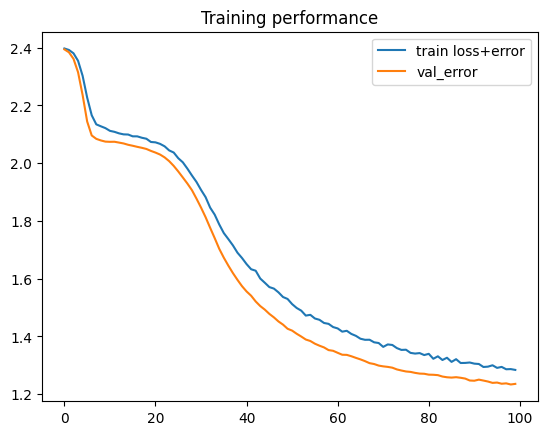

In [94]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

### **混淆矩阵**

In [96]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

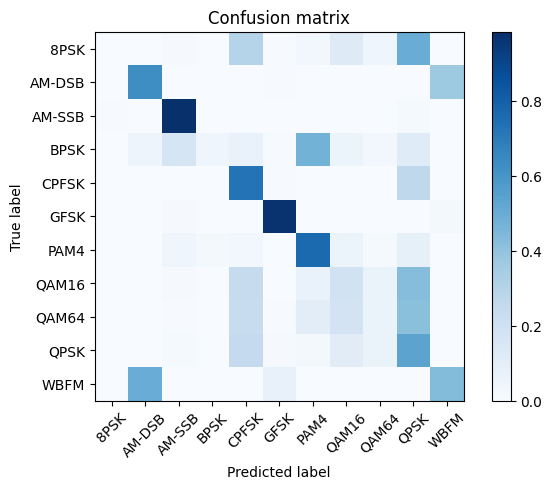

In [97]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [98]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)

SyntaxError: ignored

### **识别准确率**

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 1, 6, 128)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 1, 2, 256)         33024     
                                                                 
 dropout_3 (Dropout)         (None, 1, 2, 256)         0         
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 1, 6, 256)        0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 1, 2, 80)         

In [16]:
print(model.input[0])

Tensor("strided_slice_1:0", shape=(2, 128), dtype=float32)


In [ ]:
count_num = 0
#for i in range(-20,22,2):
type_signal = ('PAM4',18)

def pd(pred):
    signal_type = [b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']
    md = -1
    numb = -1
    for i in range(len(pred)):
        if pred[i] > md:
            md = pred[i]
            numb = i
    return signal_type[numb],md


for i in range(1000):
  martiral = Xd[type_signal][i]
  martiral = np.expand_dims(martiral, axis = 0)
  predictions = model.predict(martiral)[0].tolist()
  pred_name , pred_percent = pd(predictions) 
  print(pred_name, 100*pred_percent , '%' , sep = '')
  if pred_name == b'PAM4':
    count_num+=1
print(count_num/(1000*21)*100,'%',sep='')

In [206]:

# # Load pre-trained image recognition model
model_input_layer = model.layers[0].input
model_output_layer = model.layers[-1].output

# Choose an ImageNet object to fake 如何确认被欺骗的对象的目标编号
object_type_to_fake = 6
signal_type = ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']

#需要被诱骗的电磁信号
origin_name = ('CPFSK',18)   #('AM-DSB',4)#('PAM4',8)#('QPSK',10)
origin_numb = 4
signal_faked = Xd[origin_name][3]   #被诱骗信号对象组
original_signal = signal_faked      #原始信号对象组

signal_be_faked = np.expand_dims(signal_faked, axis = 0)
print(signal_be_faked.min())
print(signal_be_faked.max())
#print(signal_be_faked)
div = signal_be_faked.max()-signal_be_faked.min()
#归一化
#signal_be_faked = (signal_be_faked - signal_be_faked.min()*np.ones([1,2,128]))/(signal_be_faked.max()-signal_be_faked.min())#
#print(signal_be_faked)
max_change_above = signal_be_faked + div*np.ones([1,2,128])*0.3
max_change_below = signal_be_faked - div*np.ones([1,2,128])*0.3


hacked_signal = np.copy(signal_be_faked)

learning_rate = 0.001

cost_function = model_output_layer[0,object_type_to_fake]

tf.compat.v1.disable_eager_execution()
gradient_function = K.gradients(cost_function, model_input_layer)[0]

grab_cost_and_gradients_from_model = K.function([model_input_layer], [cost_function, gradient_function])  #, K.learning_phase()

cost = 0.0


-0.009008788
0.009108057


In [207]:
#print('目标原始信号：',signal_type[origin_numb],'被诱骗为：',signal_type[object_type_to_fake])
def pd(pred):
    signal_type = ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
    md = -1
    numb = -1
    for i in range(len(pred)):
        if pred[i] > md:
            md = pred[i]
            numb = i
    return signal_type[numb],md

#print(hacked_signal)
num = 0
sumtry = 0
righttry = 0
while cost < 0.80:
    cost, gradients = grab_cost_and_gradients_from_model([hacked_signal,0])    # !!!!!!!!!!!!
    #print(cost,gradients)
    
    hacked_signal += gradients * learning_rate  #list(map(float,gradients))

    hacked_signal = np.clip(hacked_signal, max_change_below, max_change_above)  #
    #hacked_signal = np.clip(hacked_signal, -2.0, 2.0)               
    num += 1
    sumtry+=1;
    predictions = model.predict(hacked_signal)[0].tolist()
    pred_name , pred_percent = pd(predictions) 
    if(num<10):
      print("{} 误导目标：{}: {:.8}%".format(num, signal_type[object_type_to_fake], cost * 100 ))
      print('目标原始信号：',signal_type[origin_numb],'被诱骗为：',signal_type[object_type_to_fake])
      print('识别结果：' , pred_name, 100*pred_percent , '%' , sep = ' ')
      print('原始信号：' , signal_type[origin_numb] , 100*predictions[origin_numb] , '%' , sep = ' ')
      #print('原始信号2：' , signal_type[object_type_to_fake] , 100*predictions[object_type_to_fake] , '%' , sep = ' ')
    
    if(pred_name == signal_type[origin_numb]):
      righttry+=1
    if num > 1500:
      break
#print(righttry/sumtry)

# signal *= top_signal - low_signal
# signal += low_signal

#print(signal)
#[b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']


1 误导目标：PAM4: 3.0641073%
目标原始信号： CPFSK 被诱骗为： PAM4
识别结果： CPFSK 20.73749750852585 %
原始信号： CPFSK 20.73749750852585 %
2 误导目标：PAM4: 3.3941139%
目标原始信号： CPFSK 被诱骗为： PAM4
识别结果： QPSK 19.75364089012146 %
原始信号： CPFSK 18.775032460689545 %
3 误导目标：PAM4: 3.971127%
目标原始信号： CPFSK 被诱骗为： PAM4
识别结果： QPSK 19.064144790172577 %
原始信号： CPFSK 13.98523598909378 %
4 误导目标：PAM4: 5.8888104%
目标原始信号： CPFSK 被诱骗为： PAM4
识别结果： PAM4 17.74618923664093 %
原始信号： CPFSK 4.424368217587471 %
5 误导目标：PAM4: 17.746189%
目标原始信号： CPFSK 被诱骗为： PAM4
识别结果： PAM4 59.97750759124756 %
原始信号： CPFSK 0.11915109353139997 %
6 误导目标：PAM4: 59.977508%
目标原始信号： CPFSK 被诱骗为： PAM4
识别结果： PAM4 71.70998454093933 %
原始信号： CPFSK 0.015079723380040377 %
7 误导目标：PAM4: 71.709985%
目标原始信号： CPFSK 被诱骗为： PAM4
识别结果： PAM4 73.69061708450317 %
原始信号： CPFSK 0.009065517224371433 %
8 误导目标：PAM4: 73.690617%
目标原始信号： CPFSK 被诱骗为： PAM4
识别结果： PAM4 74.82690215110779 %
原始信号： CPFSK 0.00650471993139945 %
9 误导目标：PAM4: 74.826902%
目标原始信号： CPFSK 被诱骗为： PAM4
识别结果： PAM4 75.52489042282104 %
原始信号： CPFSK 

In [208]:
signal = hacked_signal[0]

In [209]:
#方法一，利用关键字
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#定义坐标轴
# fig = plt.figure()
# ax1 = plt.axes(projection='3d')
#ax = fig.add_subplot(111,projection='3d')  #这种方法也可以画多个子图

sig = signal
import numpy as np
z1 = np.linspace(0,10,128)
x1 = original_signal[0]
y1 = original_signal[1]

z2 = np.linspace(0,10,128)
x2 = sig[0]
y2 = sig[1]# * 0.005

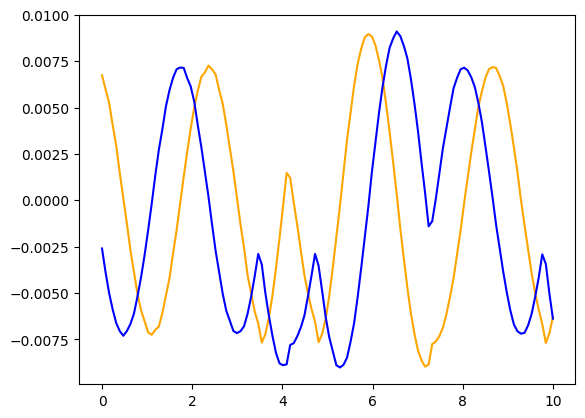

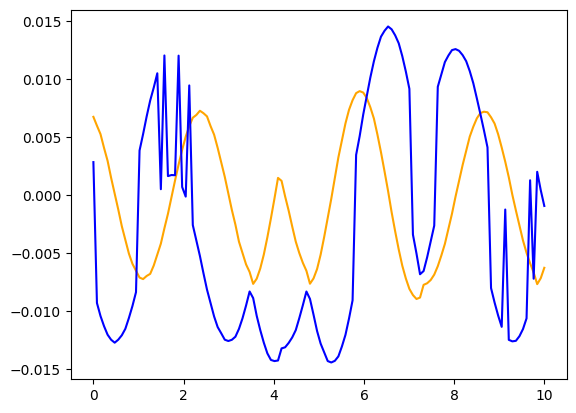

PAM4 78.6781370639801 %
CPFSK 0.0028859447411377914 %


In [210]:
plt.plot(z1,x1,'orange')
plt.plot(z1,y1,'blue')
plt.show()
plt.plot(z2,x2,'orange')
plt.plot(z2,y2,'blue')
plt.show()
signal = np.expand_dims(signal,axis=0)
predictions = model.predict(signal)[0].tolist()
pred_name , pred_percent = pd(predictions) 
print(pred_name, 100*pred_percent , '%' ,)
print(signal_type[origin_numb],100*predictions[origin_numb],'%')

In [23]:
print(np.size(model.predict(hacked_signal)))
print(model.predict(hacked_signal)[0].tolist())

11
[0.19966906309127808, 3.1477023298975837e-07, 0.000368575711036101, 0.05297984182834625, 0.1731184720993042, 0.0002911378105636686, 0.035321544855833054, 0.16157284379005432, 0.17291110754013062, 0.2037666141986847, 4.6092063143987616e-07]


In [24]:
signal_faked = Xd[(b'QPSK',18)][1]
#归一化
top_signal = max(max(signal_faked[0]),max(signal_faked[1]))
low_signal = min(min(signal_faked[0]),min(signal_faked[1]))
signal_be_faked = [[],[]]
for i in range(2):
  for j in range(128):
    signal_be_faked[i].append(( signal_faked[i][j] - low_signal ) / ( top_signal - low_signal )) #= ( signal_faked[i][j] - low_signal ) / ( top_signal - low_signal )
print(signal_be_faked)


KeyError: ignored

In [25]:
print(model_output_layer[1,0])
print(model_output_layer[0,2])
print(model_output_layer[0,2])
print(model_output_layer[0,3])
print(model_output_layer[0,4])
print(model_output_layer[0,5])
print(model_output_layer[0,6])
print(model_output_layer[0,7])
print(model_output_layer[0,8])
print(model_output_layer[0,9])
print(model_output_layer[0,10])


Tensor("strided_slice_3:0", shape=(), dtype=float32)
Tensor("strided_slice_4:0", shape=(), dtype=float32)
Tensor("strided_slice_5:0", shape=(), dtype=float32)
Tensor("strided_slice_6:0", shape=(), dtype=float32)
Tensor("strided_slice_7:0", shape=(), dtype=float32)
Tensor("strided_slice_8:0", shape=(), dtype=float32)
Tensor("strided_slice_9:0", shape=(), dtype=float32)
Tensor("strided_slice_10:0", shape=(), dtype=float32)
Tensor("strided_slice_11:0", shape=(), dtype=float32)
Tensor("strided_slice_12:0", shape=(), dtype=float32)
Tensor("strided_slice_13:0", shape=(), dtype=float32)


# 学姐代码

In [11]:

def original_input(index):  #调整输入输出的尺度
    original_image = xTest[index]
    original_image = tf.convert_to_tensor(original_image.reshape(1,2,128))
    original_label_y = yTest_ohe[index]
    original_label = np.argwhere(original_label_y==1)
    original_label_re = np.reshape(original_label, (1,)).astype('int64')
    return original_image,original_label

original_image, original_label = original_input(index)
original_label = np.reshape(original_label, (1,)).astype('int64')
input_image = tf.constant(original_image)
input_image = tf.constant(original_image)

# 计算梯度
loss_fn = tf.nn.sparse_softmax_cross_entropy_with_logits  #损失函数
with tf.GradientTape() as g:
    g.watch(input_image)
    loss = loss_fn(labels=original_label, logits=model(input_image))  #model为你搭建的网络
gradient = g.gradient(loss, input_image)

gradient_sign = np.sign(gradient)
adversarial = input_image + eps * gradient_sign




TypeError: ignored

In [10]:
import tensorflow as tf
import numpy as np
import pickle, keras
import os,random
import scipy.io
f = open(r'/content/drive/MyDrive/Colab Notebooks/RML2016.10a_dict.pkl', 'rb')
dataDict = pickle.load(f,encoding='bytes')

data = []
labels = []
for d in dataDict:
   signals=dataDict[d]
   for s in signals:
     data.append(np.array(s))
     labels.append(d)
data = np.array(data)
labels = np.array(labels)

length = len(data)

# 手动划分
indices = random.sample(range(0,length),length)
xTrain = []
yTrain = []
iTrain = []
for i in range(0,(length-1)//2):
  xTrain.append(data[indices[i]])
  yTrain.append(labels[indices[i]])
  iTrain.append(indices[i])
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
iTrain = np.array(iTrain)

xTest = []
yTest = []
iTest = []
for i in range((length-1)//2, length):
  xTest.append(data[indices[i]])
  yTest.append(labels[indices[i]])
  iTest.append(indices[i])
xTest = np.array(xTest)
yTest = np.array(yTest)
iTest = np.array(iTest)


from sklearn.preprocessing import OneHotEncoder, LabelEncoder

le = LabelEncoder()
yTrain_le = le.fit_transform(yTrain[0])
yTest_le = le.fit_transform(yTest[0])
yTrain_le = yTrain_le.reshape(len(yTrain_le), 1)
yTest_le = yTest_le.reshape(len(yTest_le), 1)
enc = OneHotEncoder(categories = 'auto',sparse = False )
yTrain_ohe = enc.fit_transform(yTrain_le)
yTest_ohe = enc.fit_transform(yTest_le)


# from tensorflow.keras.models import load_model
# filepath = r'D:\Project\Adversarial attack\Model\model3.h5'  #加载已经训练好的模型
# model = load_model(filepath)


#输入信号格式转换
def original_input(index):
    original_image = xTest[index]
    original_image = tf.convert_to_tensor(original_image.reshape(1,2,128))
    original_label_y = yTest_ohe[index]
    original_label = np.argwhere(original_label_y==1)
    original_label_re = np.reshape(original_label, (1,)).astype('int64')
    example_targeted_pred = model.predict(original_image)
    example = model(original_image)
    predict = np.squeeze(example)  # np.squeeze 降维

    print('original_label=',original_label,'\n','original_pred=',example_targeted_pred,np.max(example_targeted_pred))
    return original_image,original_label,


eps = 0.6  #设置扰动因子
index = 1  #随机选择一个输入信号测试
original_image, original_label= original_input(index)
original_label = np.reshape(original_label, (1,)).astype('int64')
original = np.squeeze(original_image)
input_image = tf.constant(original_image)
print(model(input_image).shape)
input_image = tf.constant(original_image)
loss_fn = tf.nn.sparse_softmax_cross_entropy_with_logits
with tf.GradientTape() as g:
    g.watch(input_image)
    predictions = model(input_image)
    loss = loss_fn(labels=original_label, logits=model(input_image))
predict = np.squeeze(predictions)  # np.squeeze 降维
top_k = predict.argsort()[-3:][::-1]
predictions_id6 = top_k[0]
print(" loss={} label={}".format(loss, predictions_id6))
gradient = g.gradient(loss, input_image)

gradient_sign = np.sign(gradient)
adversarial = input_image + eps * gradient_sign
adv = np.squeeze(adversarial)
predictions2 = model(adversarial)
predict2 = np.squeeze(predictions2)  # np.squeeze 降维
top_k2 = predict2.argsort()[-3:][::-1]
predictions_id7 = top_k2[0]
print('adversarial_pred=', model.predict(adversarial), 'adv_label=', predictions_id7)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: ignored